# Objective:
 To predict the eructation location based on thermistor data.

Assumptions:
1. Peaks in CH4 conc. represent eructations.
2. Gas data is sampled at 500ms approx.
3. Thermistor data is sampled at 40ms approx.

## Approach:
1. We know that the peak values in the ch4 gas data represent the eructations.
2. We could find the threshold value for those peaks and then label the data.
3. Once we have the labels for eructation, we can merge the gas and thermistor data properly based on the time.
4.  Once merged, we could drop the gas columns and just have the time, thermistor temperatures and the labels.
5. Final step is to train the model based on this.

#Importing Libraries


In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score


# Loading the data

In [3]:
#Function to read data
def read_data(file_path):
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except pd.errors.ParserError:
        print(f"Error: Unable to parse the CSV file '{file_path}'. Check its format.")
        return None
    return df

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'zelp/data'
GOOGLE_DRIVE_PATH = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print('List files: ', os.listdir(GOOGLE_DRIVE_PATH))

List files:  ['cowA_therm-0.csv', 'cowA_gas.csv', 'cowA_therm-2.csv', 'cowB_therm-0.csv', 'cowB_therm-2.csv', 'cowB_gas.csv', 'merged_df.csv', 'merged_data.csv']


In [6]:
cowA_therm0_df = read_data(os.path.join(GOOGLE_DRIVE_PATH, 'cowA_therm-0.csv'))
cowA_therm0_df

,time_ms,thermistor_id,temperature,raw
0,1.723507e+12,0.0,28.334112,1911.0
1,1.723507e+12,0.0,28.582122,1901.0
2,1.723507e+12,0.0,28.855607,1890.0
3,1.723507e+12,0.0,28.830715,1891.0
4,1.723507e+12,0.0,29.079906,1881.0
...,...,...,...,...
99994,1.723511e+12,0.0,29.104858,1880.0
99995,1.723511e+12,0.0,29.279698,1873.0
99996,1.723511e+12,0.0,29.404770,1868.0
99997,1.723511e+12,0.0,29.555064,1862.0


In [7]:
cowA_therm2_df = read_data(os.path.join(GOOGLE_DRIVE_PATH, 'cowA_therm-2.csv'))
cowA_therm2_df

,time_ms,thermistor_id,temperature,raw
0,1723507200030,2,26.174637,1999
1,1723507200070,2,26.345016,1992
2,1723507200110,2,26.345016,1992
3,1723507200150,2,26.613211,1981
4,1723507200193,2,26.710878,1977
...,...,...,...,...
99995,1723511199830,2,27.004344,1965
99996,1723511199870,2,27.004344,1965
99997,1723511199910,2,26.979861,1966
99998,1723511199950,2,26.930911,1968


In [8]:
cowA_gas_df = read_data(os.path.join(GOOGLE_DRIVE_PATH, 'cowA_gas.csv'))
cowA_gas_df

,epoch_ms,co2,co2temp,ch4,ch4temp
0,1723507200500,0.782,34.849998,0.068,33.849998
1,1723507201000,0.782,34.849998,0.068,33.849998
2,1723507201500,0.763,34.849998,0.068,33.849998
3,1723507202000,0.763,34.849998,0.068,33.849998
4,1723507202500,0.805,34.849998,0.077,33.849998
...,...,...,...,...,...
7994,1723511197500,1.123,35.849998,0.084,33.849998
7995,1723511198000,1.123,35.849998,0.084,33.849998
7996,1723511198500,1.158,35.849998,0.087,33.849998
7997,1723511199000,1.158,35.849998,0.087,33.849998


In [9]:
cowB_therm0_df = read_data(os.path.join(GOOGLE_DRIVE_PATH, 'cowB_therm-0.csv'))
cowB_therm0_df

,time_ms,thermistor_id,temperature,raw
0,1723635162289,0,25.446897,2029
1,1723635162330,0,25.374333,2032
2,1723635162370,0,25.543706,2025
3,1723635162411,0,25.446897,2029
4,1723635162449,0,25.543706,2025
...,...,...,...,...
99994,1723639161674,0,28.830715,1891
99995,1723639161711,0,28.805829,1892
99996,1723639161753,0,28.656638,1898
99997,1723639161791,0,28.631793,1899


In [10]:
cowB_therm2_df = read_data(os.path.join(GOOGLE_DRIVE_PATH, 'cowB_therm-2.csv'))
cowB_therm2_df

,time_ms,thermistor_id,temperature,raw
0,1.723635e+12,2.0,26.442476,1988.0
1,1.723635e+12,2.0,26.466853,1987.0
2,1.723635e+12,2.0,26.466853,1987.0
3,1.723635e+12,2.0,26.442476,1988.0
4,1.723635e+12,2.0,26.369374,1991.0
...,...,...,...,...
99993,1.723639e+12,2.0,30.133351,1839.0
99994,1.723639e+12,2.0,30.082927,1841.0
99995,1.723639e+12,2.0,30.057724,1842.0
99996,1.723639e+12,2.0,29.881495,1849.0


In [11]:
cowB_gas_df = read_data(os.path.join(GOOGLE_DRIVE_PATH, 'cowB_gas.csv'))
cowB_gas_df

,epoch_ms,co2,co2temp,ch4,ch4temp
0,1723635162500,0.643,35.849998,0.059,33.849998
1,1723635163000,0.643,35.849998,0.056,33.849998
2,1723635163500,0.580,35.849998,0.056,33.849998
3,1723635164000,0.580,35.849998,0.056,33.849998
4,1723635164500,0.553,35.849998,0.056,33.849998
...,...,...,...,...,...
7994,1723639159500,1.970,35.849998,0.077,33.849998
7995,1723639160000,1.970,35.849998,0.077,33.849998
7996,1723639160500,2.059,35.849998,0.078,33.849998
7997,1723639161000,2.059,35.849998,0.078,33.849998


It turns out that the gas data is sampled much less frequently than the thermistor data.
Sampling rate:
1.   500ms for gas
2.   40ms for thermistor

approximately

# Understanding the data

In [12]:
def data_insights(df):
  print(f'info:\n ')
  display(df.info())
  print(f'\ndesc:\n')
  display(df.describe())
  print(f'\nunique:\n')
  display(df.nunique())
  print(f'\nnulls:\n {df.isnull().sum()}')
  print(f'duplicates: {df.duplicated().sum()}')

Analysing cowA_therm0_df





In [13]:
data_insights(cowA_therm0_df)

info:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time_ms        97498 non-null  float64
 1   thermistor_id  97498 non-null  float64
 2   temperature    97498 non-null  float64
 3   raw            97498 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


None


desc:



,time_ms,thermistor_id,temperature,raw
count,9.749800e+04,97498.0,97498.000000,97498.000000
mean,1.723509e+12,0.0,29.188419,1877.230128
std,1.168023e+06,0.0,2.138149,69.148568
min,1.723507e+12,0.0,-273.150000,0.000000
25%,1.723508e+12,0.0,28.160844,1830.000000
50%,1.723509e+12,0.0,29.379743,1869.000000
75%,1.723510e+12,0.0,30.360596,1918.000000
max,1.723511e+12,0.0,200.729041,2113.000000



unique:



,0
time_ms,97498
thermistor_id,1
temperature,617
raw,617



nulls:
 time_ms          2501
thermistor_id    2501
temperature      2501
raw              2501
dtype: int64
duplicates: 2500


There seems to be some duplicates, missing values and some outliers as in the temperature column for cowA_therm0. Lets visualize the temperature against time.

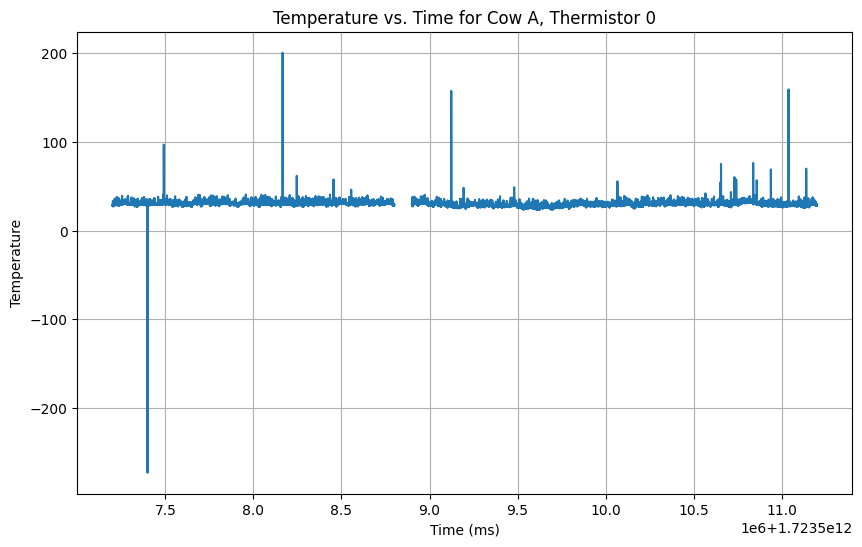

In [14]:


plt.figure(figsize=(10, 6))
plt.plot(cowA_therm0_df['time_ms'], cowA_therm0_df['temperature'])
plt.xlabel('Time (ms)')
plt.ylabel('Temperature')
plt.title('Temperature vs. Time for Cow A, Thermistor 0')
plt.grid(True)
plt.show()


Lets remove outliers (too high or too steap peaks) first for better visualization



Number of outliers removed: 4251


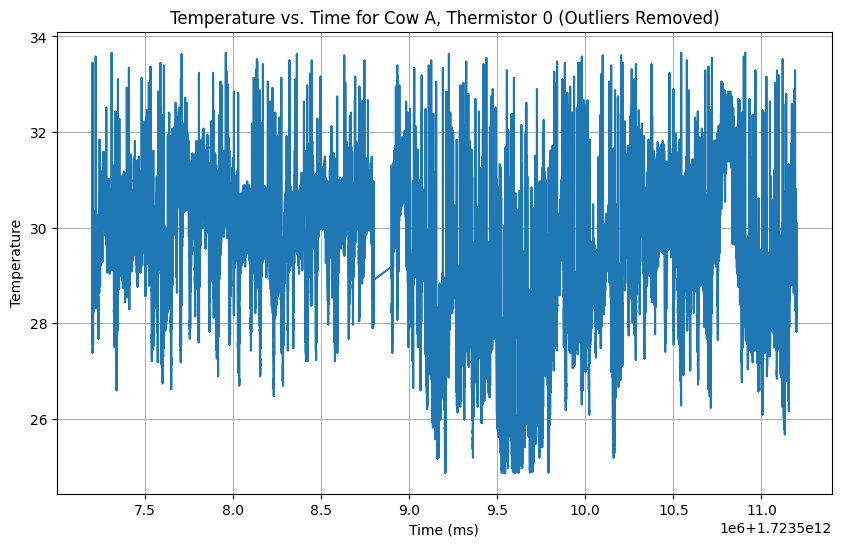

In [15]:

# Remove outliers using IQR method
Q1 = cowA_therm0_df['temperature'].quantile(0.25)
Q3 = cowA_therm0_df['temperature'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
cowA_therm0_df_no_outliers = cowA_therm0_df[
    (cowA_therm0_df['temperature'] >= lower_bound) & (cowA_therm0_df['temperature'] <= upper_bound)
]

# Print the number of outliers removed
print(f"Number of outliers removed: {len(cowA_therm0_df) - len(cowA_therm0_df_no_outliers)}")

# Visualize the data without outliers
plt.figure(figsize=(10, 6))
plt.plot(cowA_therm0_df_no_outliers['time_ms'], cowA_therm0_df_no_outliers['temperature'])
plt.xlabel('Time (ms)')
plt.ylabel('Temperature')
plt.title('Temperature vs. Time for Cow A, Thermistor 0 (Outliers Removed)')
plt.grid(True)
plt.show()




the slanted line just before 9.0 on x-axis represent missing values.

#### Creating datetime index for better analysis



In [16]:
cowA_therm0_df_no_outliers


,time_ms,thermistor_id,temperature,raw
0,1.723507e+12,0.0,28.334112,1911.0
1,1.723507e+12,0.0,28.582122,1901.0
2,1.723507e+12,0.0,28.855607,1890.0
3,1.723507e+12,0.0,28.830715,1891.0
4,1.723507e+12,0.0,29.079906,1881.0
...,...,...,...,...
99994,1.723511e+12,0.0,29.104858,1880.0
99995,1.723511e+12,0.0,29.279698,1873.0
99996,1.723511e+12,0.0,29.404770,1868.0
99997,1.723511e+12,0.0,29.555064,1862.0


In [17]:

start_time = pd.to_datetime('2024-08-13 00:00:00.069')
end_time = pd.to_datetime('2024-08-13 01:06:39.989')

# Create the datetime index with a 40ms sampling rate
datetime_index = pd.date_range(start=start_time, end=end_time, freq='40ms')

# Create a DataFrame with the datetime index
df = pd.DataFrame({'datetime': datetime_index})

# Display the DataFrame
df

,datetime
0,2024-08-13 00:00:00.069
1,2024-08-13 00:00:00.109
2,2024-08-13 00:00:00.149
3,2024-08-13 00:00:00.189
4,2024-08-13 00:00:00.229
...,...
99994,2024-08-13 01:06:39.829
99995,2024-08-13 01:06:39.869
99996,2024-08-13 01:06:39.909
99997,2024-08-13 01:06:39.949


In [18]:
cowA_therm0_df_no_outliers['datetime'] = pd.to_datetime(cowA_therm0_df_no_outliers['time_ms'], unit='ms')
merged_df = pd.merge(df, cowA_therm0_df_no_outliers, on=['datetime', 'datetime'], how='outer')
merged_df = merged_df.set_index('datetime')
merged_df = merged_df.drop(columns=['time_ms'])
merged_df

,thermistor_id,temperature,raw
datetime,,,
2024-08-13 00:00:00.069,0.0,28.334112,1911.0
2024-08-13 00:00:00.109,0.0,28.582122,1901.0
2024-08-13 00:00:00.149,0.0,28.855607,1890.0
2024-08-13 00:00:00.189,NaN,NaN,NaN
2024-08-13 00:00:00.193,0.0,28.830715,1891.0
...,...,...,...
2024-08-13 01:06:39.829,0.0,29.104858,1880.0
2024-08-13 01:06:39.869,0.0,29.279698,1873.0
2024-08-13 01:06:39.909,0.0,29.404770,1868.0


### Resampling for every 1 minute better visualization

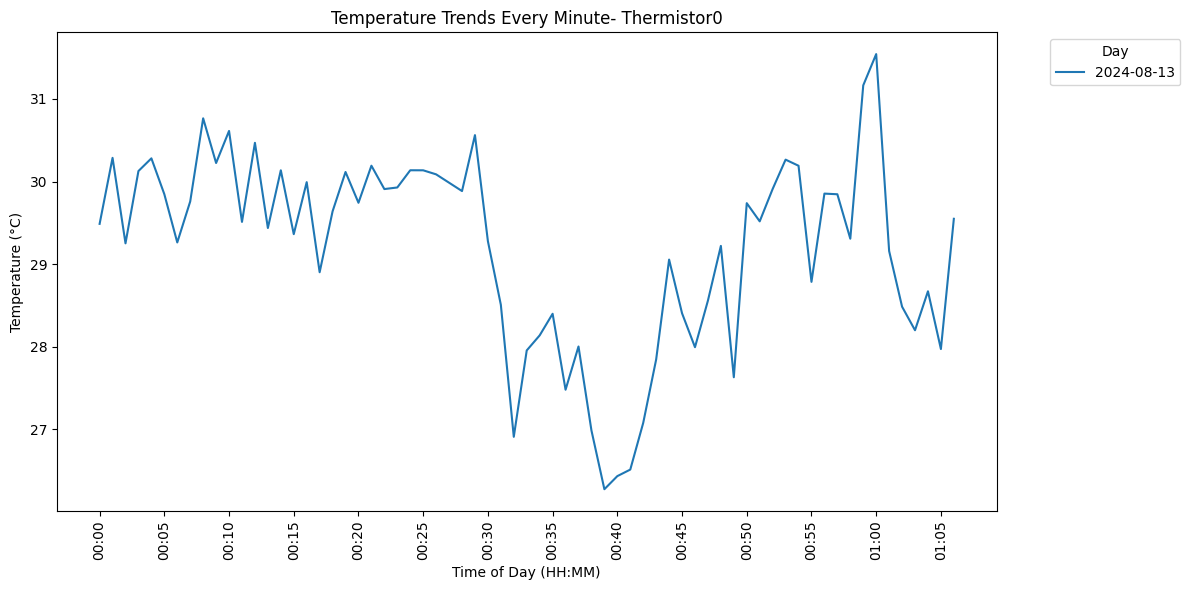

In [19]:
df = merged_df.copy()
# Resample to 1-minute intervals and compute the mean
df_resampled = df.resample('1T').mean().reset_index()

# Extract hour and minute to represent time of day
df_resampled['time'] = df_resampled['datetime'].dt.strftime('%H:%M')

# Extract the date to use as hue
df_resampled['day'] = df_resampled['datetime'].dt.date

plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='temperature', data=df_resampled, hue='day', palette='tab10')


all_times = df_resampled['time'].unique()

n = 5
selected_times = all_times[::n]

# Set the selected times as x-axis ticks
plt.xticks(selected_times, rotation=90)

plt.xlabel("Time of Day (HH:MM)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trends Every Minute- Thermistor0")
plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('./temperature_trend_per_minute.pdf', dpi=1000)
plt.show()


Observations:
1. The sharp drop and subsequent fluctuations might indicate specific events or changes in the environment or cow's activity.
2. Identifying these patterns can help correlate temperature changes with eructation events or other behaviors.
3. The temperature fluctuates between approximately 27°C and 31°C over the observed period.
4. There doesn't seem to be any cyclic or periodic trend given the data span is short

Lets try to gain more insights by decomposition on much smaller frequency.

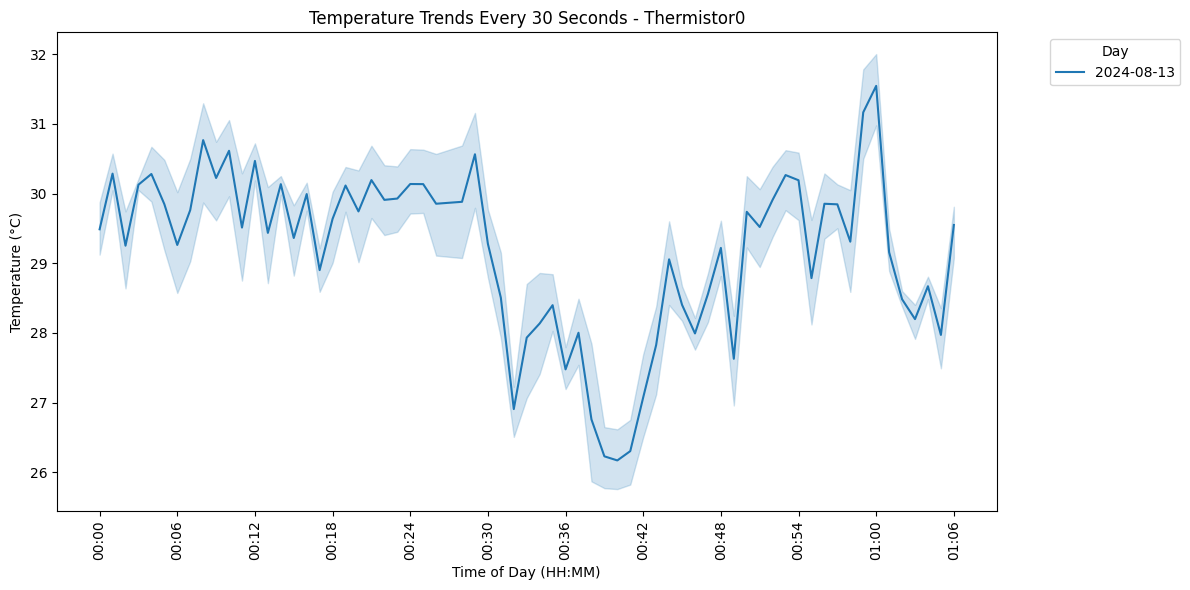

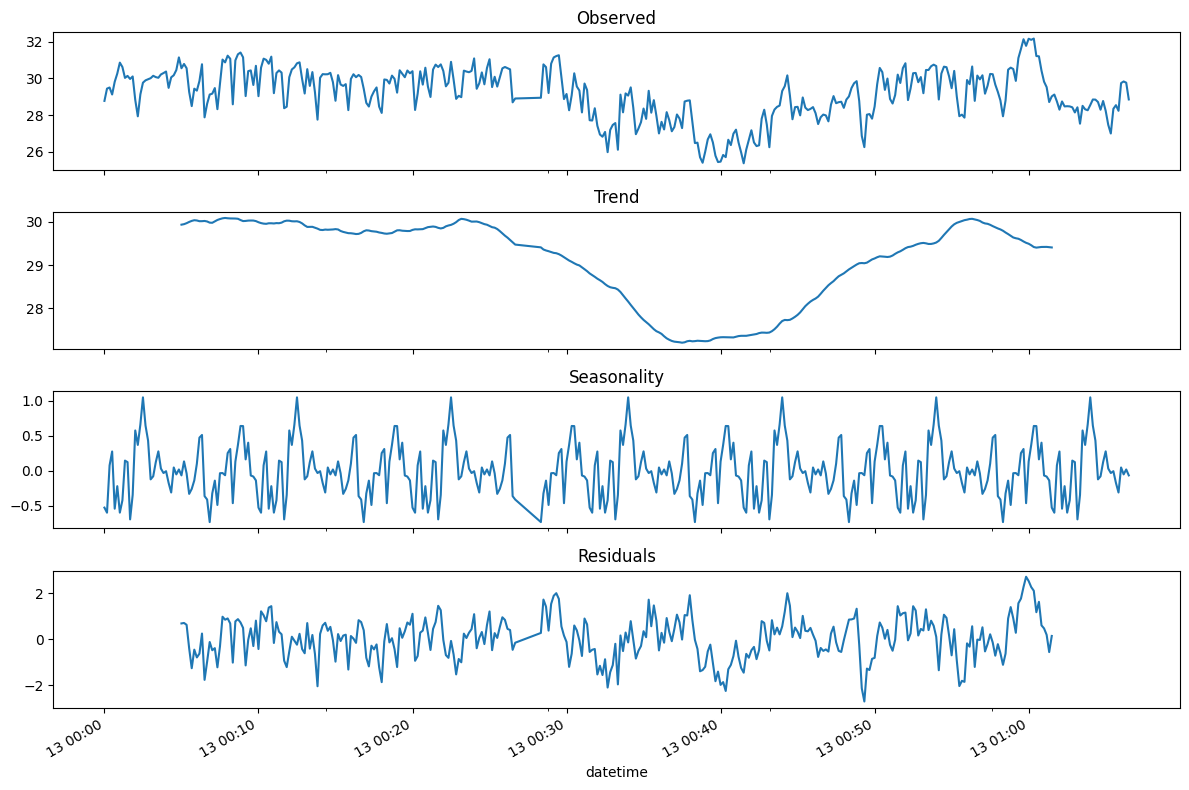

In [20]:
df = merged_df.copy()

# Resample to 30-second intervals and compute the mean
df_resampled = df.resample('10S').mean().reset_index()

# Extract hour and minute to represent time of day
df_resampled['time'] = df_resampled['datetime'].dt.strftime('%H:%M')

# Extract the date to use as hue
df_resampled['day'] = df_resampled['datetime'].dt.date

plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='temperature', data=df_resampled, hue='day', palette='tab10')

# Reduce x-axis ticks
all_times = df_resampled['time'].unique()
n = max(1, len(all_times) // 10)  # Adjust to limit number of ticks
selected_times = all_times[::n]

plt.xticks(selected_times, rotation=90)
plt.xlabel("Time of Day (HH:MM)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trends Every 30 Seconds - Thermistor0")
plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('./temperature_trend_per_30s.pdf', dpi=1000)
plt.show()

# ---- Perform Time Series Decomposition ----
df_decomposed = df_resampled.set_index('datetime')['temperature'].dropna()

# Since the original data is sampled at 40ms, and we resample at 30s, we estimate periodicity:
estimated_period = 60

result = seasonal_decompose(df_decomposed, model='additive', period=estimated_period)

# Plot Decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
result.observed.plot(ax=axes[0], title='Observed')
result.trend.plot(ax=axes[1], title='Trend')
result.seasonal.plot(ax=axes[2], title='Seasonality')
result.resid.plot(ax=axes[3], title='Residuals')

plt.tight_layout()
plt.savefig('./temperature_decomposition.pdf', dpi=1000)
plt.show()


Key Points
1. Uniformity: The data isn't completely uniform; there are clear patterns and changes over time.
2. Seasonal Component: there is a seasonal component, indicating regular, repeating changes in temperature.
3. SARIMA Model could be used for this as it captures both seasonality and trend

Overall, the data shows both a general trend and regular fluctuations, with some random noise.

#### Let's also look for best interpolation method for our data to handle missing values

In [21]:
df.isnull().sum()

,0
thermistor_id,24640
temperature,24640
raw,24640


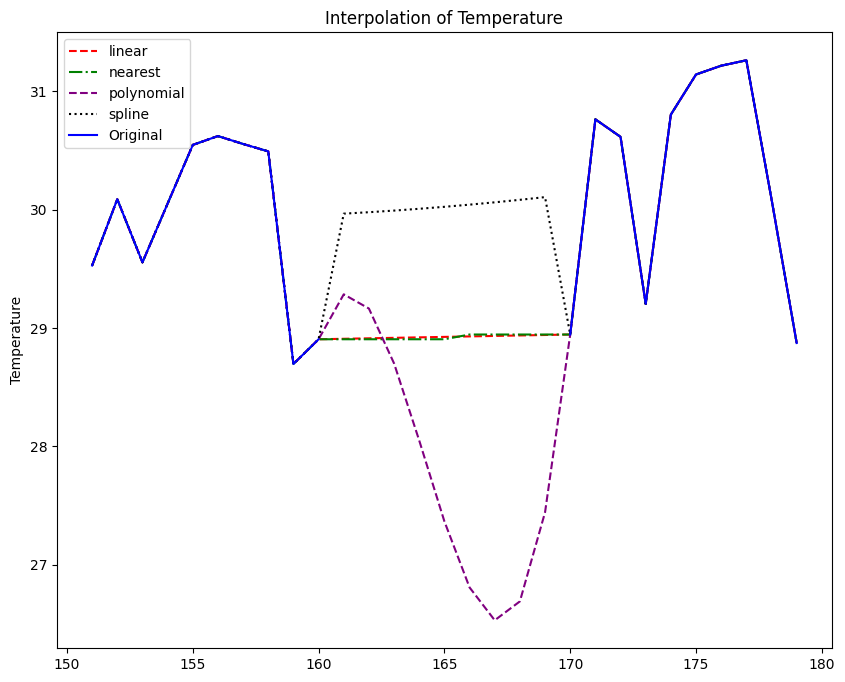

In [22]:

missing_indices = df_resampled['temperature'].isnull()

window_size = 10
missing_locations = np.where(missing_indices)[0]
start_index = np.maximum(0, missing_locations - window_size)
end_index = np.minimum(len(df_resampled) -1, missing_locations + window_size)

# Slice the DataFrame to get the chunk
df_chunk = df_resampled.iloc[start_index[0]: end_index[-1] + 1]

# Perform the interpolations on the selected chunk
df_chunk['linear_interp'] = df_chunk['temperature'].interpolate(method='linear')
df_chunk['nearest_interp'] = df_chunk['temperature'].interpolate(method='nearest')
df_chunk['spline_interp'] = df_chunk['temperature'].interpolate(method='spline', order=2)
df_chunk['polynomial_interp'] = df_chunk['temperature'].interpolate(method='polynomial', order=3)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(df_chunk.index, df_chunk['linear_interp'], linestyle='--', color='red', label='linear')
plt.plot(df_chunk.index, df_chunk['nearest_interp'], linestyle='-.', color='green', label='nearest')

plt.plot(df_chunk.index, df_chunk['polynomial_interp'], linestyle='--', color='purple', label='polynomial')
plt.plot(df_chunk.index, df_chunk['spline_interp'], linestyle=':', color='black', label='spline')
plt.plot(df_chunk.index, df_chunk['temperature'], label='Original', color='blue')
plt.legend()
plt.ylabel('Temperature')
plt.title('Interpolation of Temperature')
plt.show()


lets go with spline as for temperature data, which is typically continuous and smooth, the spline interpolation often provides the best balance between smoothness and accuracy. It captures the underlying trend without introducing unnecessary oscillations.

Analysing cowA_therm2_df


In [23]:
data_insights(cowA_therm2_df)

info:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   time_ms        100000 non-null  int64  
 1   thermistor_id  100000 non-null  int64  
 2   temperature    100000 non-null  float64
 3   raw            100000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


None


desc:



,time_ms,thermistor_id,temperature,raw
count,1.000000e+05,100000.0,100000.000000,100000.000000
mean,1.723509e+12,2.0,26.640547,1980.733220
std,1.154706e+06,0.0,2.266867,91.522679
min,1.723507e+12,2.0,21.052418,349.000000
25%,1.723508e+12,2.0,25.036184,1910.000000
50%,1.723509e+12,2.0,26.930911,1968.000000
75%,1.723510e+12,2.0,28.358887,2046.000000
max,1.723511e+12,2.0,97.942428,2213.000000



unique:



,0
time_ms,100000
thermistor_id,1
temperature,635
raw,635



nulls:
 time_ms          0
thermistor_id    0
temperature      0
raw              0
dtype: int64
duplicates: 0


This one looks clean mostly




Number of outliers removed: 278


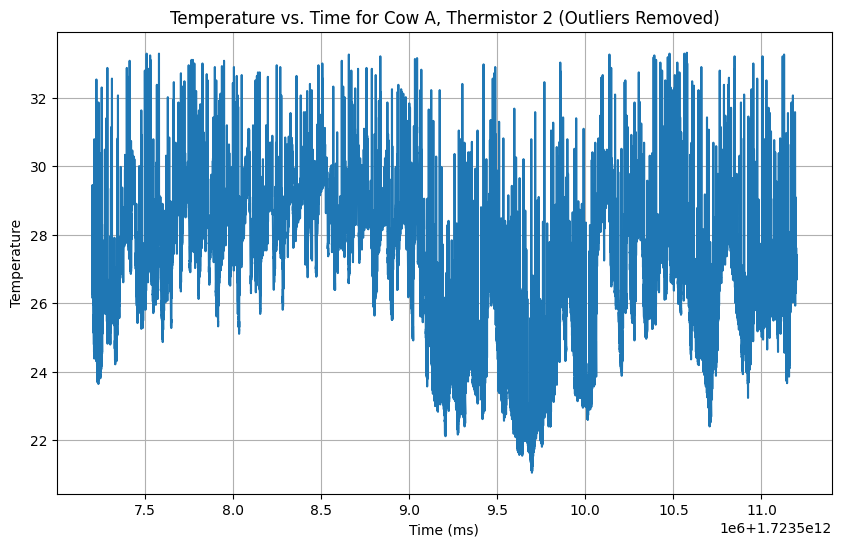

In [24]:
# Remove outliers using IQR method
Q1 = cowA_therm2_df['temperature'].quantile(0.25)
Q3 = cowA_therm2_df['temperature'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
cowA_therm2_df_no_outliers = cowA_therm2_df[
    (cowA_therm2_df['temperature'] >= lower_bound) & (cowA_therm2_df['temperature'] <= upper_bound)
]

# Print the number of outliers removed
print(f"Number of outliers removed: {len(cowA_therm2_df) - len(cowA_therm2_df_no_outliers)}")

# Visualize the data without outliers
plt.figure(figsize=(10, 6))
plt.plot(cowA_therm2_df_no_outliers['time_ms'], cowA_therm2_df_no_outliers['temperature'])
plt.xlabel('Time (ms)')
plt.ylabel('Temperature')
plt.title('Temperature vs. Time for Cow A, Thermistor 2 (Outliers Removed)')
plt.grid(True)
plt.show()




In [25]:

cowA_therm2_df['datetime'] = pd.to_datetime(cowA_therm2_df['time_ms'], unit='ms')

cowA_therm2_df = cowA_therm2_df.set_index('datetime')
cowA_therm2_df

,time_ms,thermistor_id,temperature,raw
datetime,,,,
2024-08-13 00:00:00.030,1723507200030,2,26.174637,1999
2024-08-13 00:00:00.070,1723507200070,2,26.345016,1992
2024-08-13 00:00:00.110,1723507200110,2,26.345016,1992
2024-08-13 00:00:00.150,1723507200150,2,26.613211,1981
2024-08-13 00:00:00.193,1723507200193,2,26.710878,1977
...,...,...,...,...
2024-08-13 01:06:39.830,1723511199830,2,27.004344,1965
2024-08-13 01:06:39.870,1723511199870,2,27.004344,1965
2024-08-13 01:06:39.910,1723511199910,2,26.979861,1966


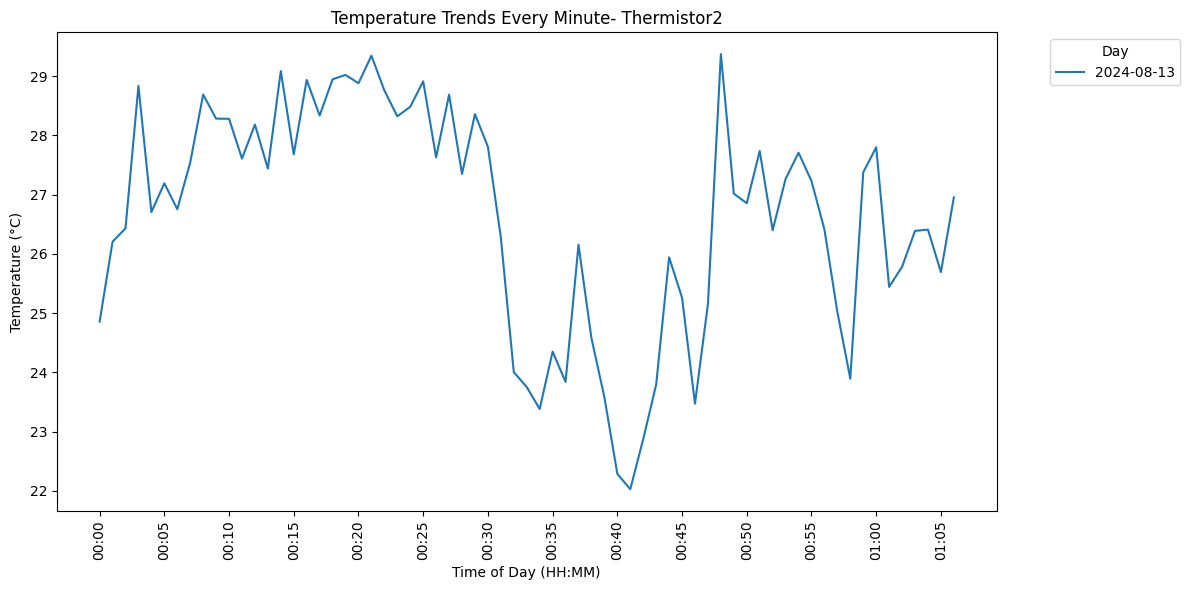

In [26]:
df = cowA_therm2_df.copy()
# Resample to 1-minute intervals and compute the mean
df_resampled = df.resample('1T').mean().reset_index()

# Extract hour and minute to represent time of day
df_resampled['time'] = df_resampled['datetime'].dt.strftime('%H:%M')

# Extract the date to use as hue
df_resampled['day'] = df_resampled['datetime'].dt.date

plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='temperature', data=df_resampled, hue='day', palette='tab10')

# Reduce x-axis ticks
# Get all time labels
all_times = df_resampled['time'].unique()

# Select every nth label (e.g., every 5th label)
n = 5  # Adjust this value to control tick frequency
selected_times = all_times[::n]

# Set the selected times as x-axis ticks
plt.xticks(selected_times, rotation=90)

plt.xlabel("Time of Day (HH:MM)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trends Every Minute- Thermistor2")
plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('./temperature_trend_per_minute.pdf', dpi=1000)
plt.show()

Observations:
1. Initial Increase: The temperature rises initially, peaking around 00:25.
2. Sharp Drop: A noticeable drop occurs around 00:30, reaching a low near 00:35.
3. Fluctuations: After the drop, the temperature fluctuates with several peaks and troughs.

Note: these similar changes were observed in thermistor0 data too, so they definitely represent something

Analysing cowA_gas_df


In [27]:
data_insights(cowA_gas_df)

info:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   epoch_ms  7999 non-null   int64  
 1   co2       7974 non-null   float64
 2   co2temp   7974 non-null   float64
 3   ch4       7974 non-null   float64
 4   ch4temp   7974 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 312.6 KB


None


desc:



,epoch_ms,co2,co2temp,ch4,ch4temp
count,7.999000e+03,7974.000000,7974.000000,7974.000000,7.974000e+03
mean,1.723509e+12,1.035904,34.987821,0.114850,3.385000e+01
std,1.154628e+06,0.357961,0.344736,0.064500,5.002535e-12
min,1.723507e+12,0.332000,34.849998,0.042000,3.385000e+01
25%,1.723508e+12,0.792000,34.849998,0.070000,3.385000e+01
50%,1.723509e+12,0.993000,34.849998,0.089000,3.385000e+01
75%,1.723510e+12,1.204000,34.849998,0.140000,3.385000e+01
max,1.723511e+12,2.905000,35.849998,0.457865,3.385000e+01



unique:



,0
epoch_ms,7999
co2,1224
co2temp,2
ch4,1285
ch4temp,1



nulls:
 epoch_ms     0
co2         25
co2temp     25
ch4         25
ch4temp     25
dtype: int64
duplicates: 0


Some missing values are there

In [28]:

cowA_gas_df['datetime'] = pd.to_datetime(cowA_gas_df['epoch_ms'], unit='ms')
cowA_gas_df = cowA_gas_df.set_index('datetime')
cowA_gas_df = cowA_gas_df.drop(columns=['epoch_ms'])
cowA_gas_df

,co2,co2temp,ch4,ch4temp
datetime,,,,
2024-08-13 00:00:00.500,0.782,34.849998,0.068,33.849998
2024-08-13 00:00:01.000,0.782,34.849998,0.068,33.849998
2024-08-13 00:00:01.500,0.763,34.849998,0.068,33.849998
2024-08-13 00:00:02.000,0.763,34.849998,0.068,33.849998
2024-08-13 00:00:02.500,0.805,34.849998,0.077,33.849998
...,...,...,...,...
2024-08-13 01:06:37.500,1.123,35.849998,0.084,33.849998
2024-08-13 01:06:38.000,1.123,35.849998,0.084,33.849998
2024-08-13 01:06:38.500,1.158,35.849998,0.087,33.849998


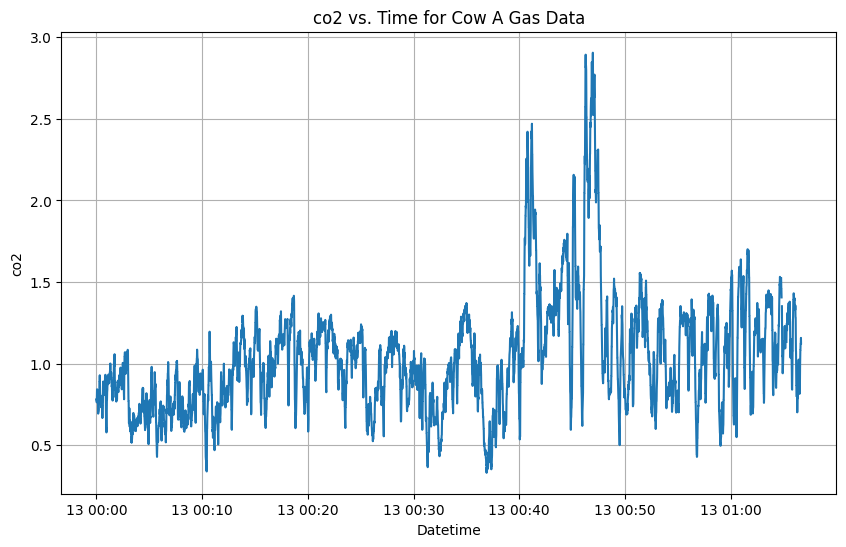

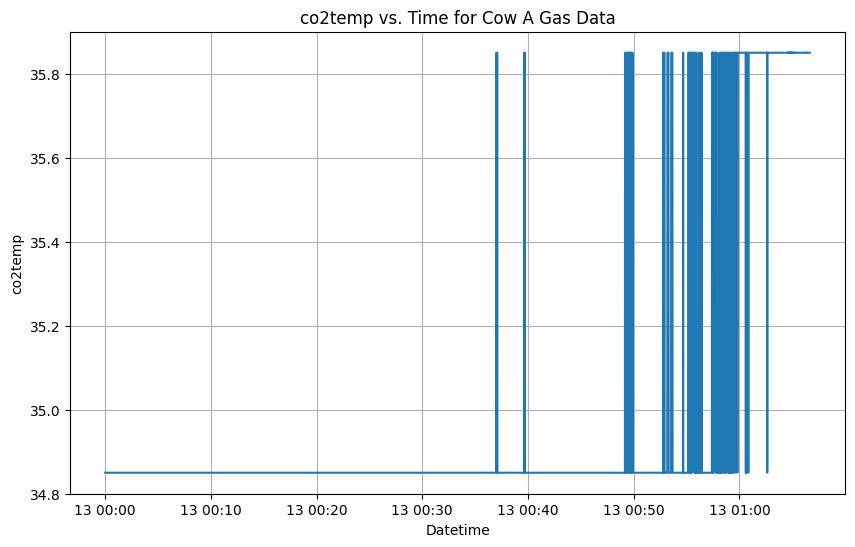

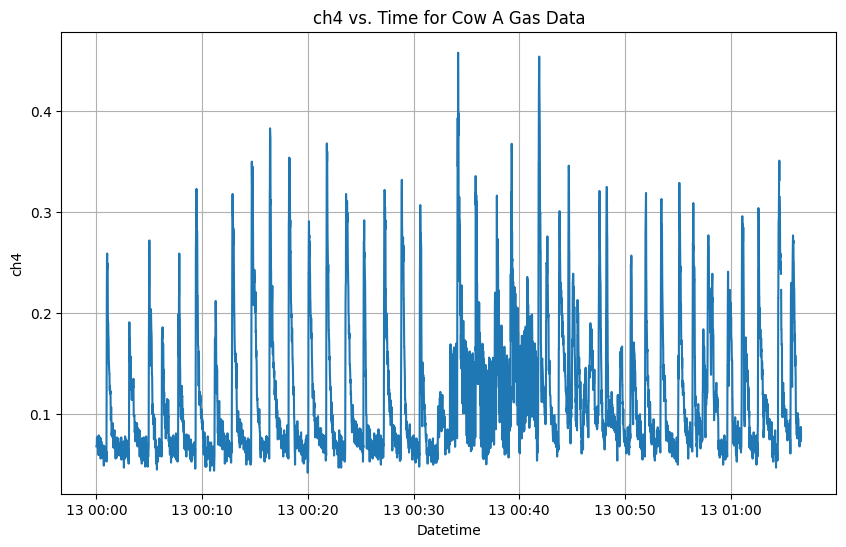

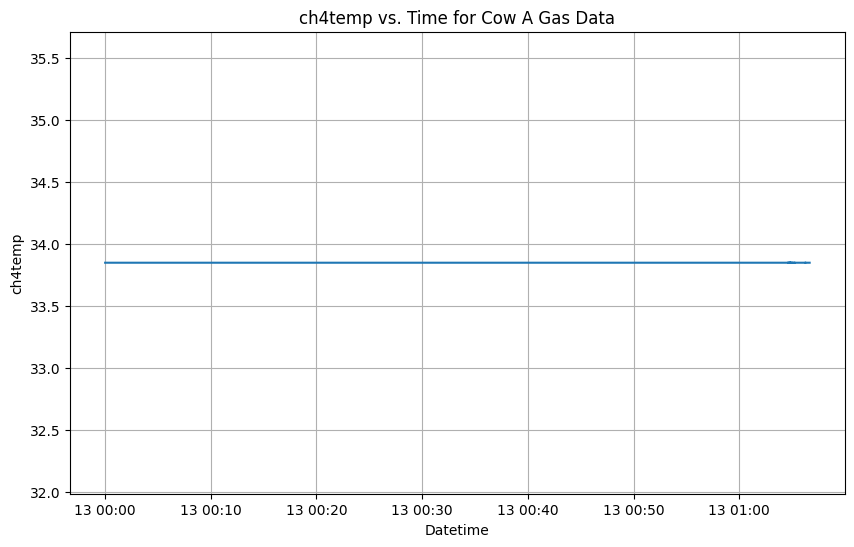

In [29]:

for col in cowA_gas_df.columns:
  plt.figure(figsize=(10, 6))
  plt.plot(cowA_gas_df.index, cowA_gas_df[col])
  plt.xlabel('Datetime')
  plt.ylabel(col)
  plt.title(f'{col} vs. Time for Cow A Gas Data')
  plt.grid(True)
  plt.show()


There are numerous sharp peaks, indicating bursts of methane concentration and it is assumed that these correspond to eructation events.

If we can figure out the threshold value, then we can label the data accordingly. Its seems to be around 0.2 but lets verify with some math.



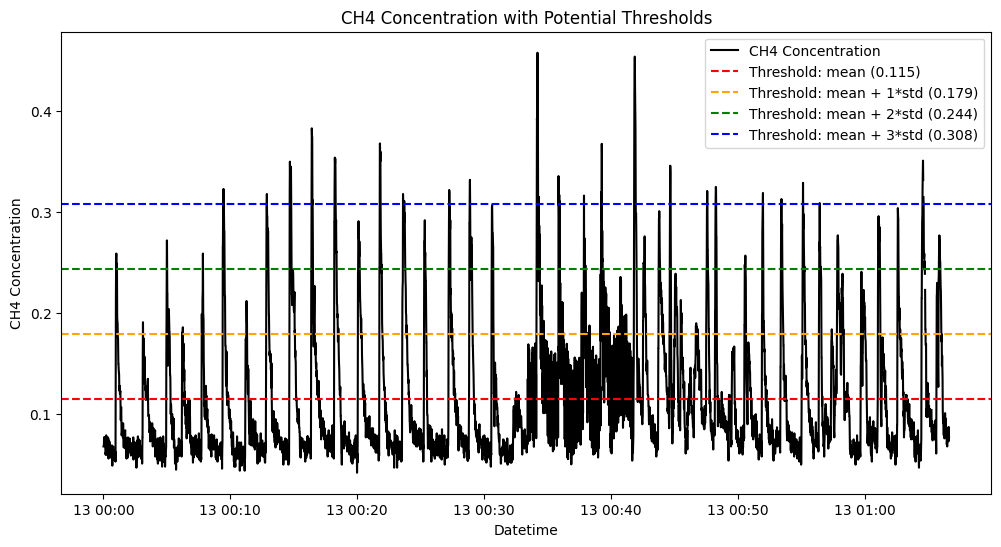

mean: 0.115
mean + 1*std: 0.179
mean + 2*std: 0.244
mean + 3*std: 0.308


In [30]:

ch4_data = cowA_gas_df['ch4']

# Calculate basic statistics
mean_ch4 = ch4_data.mean()
std_ch4 = ch4_data.std()

# Define potential thresholds with colors
thresholds = {
    'mean': (mean_ch4, 'red'),
    'mean + 1*std': (mean_ch4 + 1 * std_ch4, 'orange'),
    'mean + 2*std': (mean_ch4 + 2 * std_ch4, 'green'),
    'mean + 3*std': (mean_ch4 + 3 * std_ch4, 'blue'),

}

# Plot the data and thresholds
plt.figure(figsize=(12, 6))
plt.plot(cowA_gas_df.index, ch4_data, label='CH4 Concentration', color='black')
for label, (value, color) in thresholds.items():
    plt.axhline(y=value, linestyle='--', color=color, label=f'Threshold: {label} ({value:.3f})')

plt.title('CH4 Concentration with Potential Thresholds')
plt.xlabel('Datetime')
plt.ylabel('CH4 Concentration')
plt.legend()
plt.show()

# Print threshold values
for label, (value, _) in thresholds.items():
    print(f'{label}: {value:.3f}')

The **0.179** value seems to be best suited as it seem to capture all peak values. Lets see for cow B as well.

In [31]:


cowB_gas_df['datetime'] = pd.to_datetime(cowB_gas_df['epoch_ms'], unit='ms')
cowB_gas_df = cowB_gas_df.set_index('datetime')
cowB_gas_df = cowB_gas_df.drop(columns=['epoch_ms'])
cowB_gas_df

,co2,co2temp,ch4,ch4temp
datetime,,,,
2024-08-14 11:32:42.500,0.643,35.849998,0.059,33.849998
2024-08-14 11:32:43.000,0.643,35.849998,0.056,33.849998
2024-08-14 11:32:43.500,0.580,35.849998,0.056,33.849998
2024-08-14 11:32:44.000,0.580,35.849998,0.056,33.849998
2024-08-14 11:32:44.500,0.553,35.849998,0.056,33.849998
...,...,...,...,...
2024-08-14 12:39:19.500,1.970,35.849998,0.077,33.849998
2024-08-14 12:39:20.000,1.970,35.849998,0.077,33.849998
2024-08-14 12:39:20.500,2.059,35.849998,0.078,33.849998


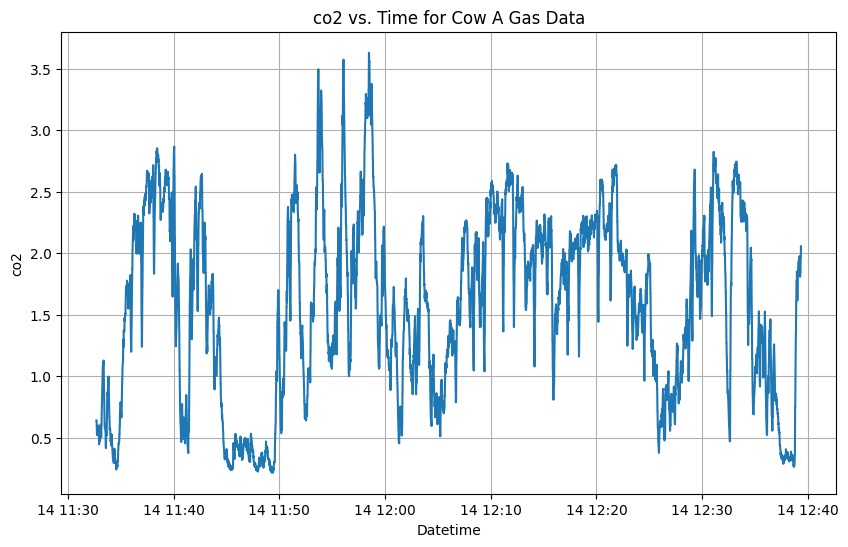

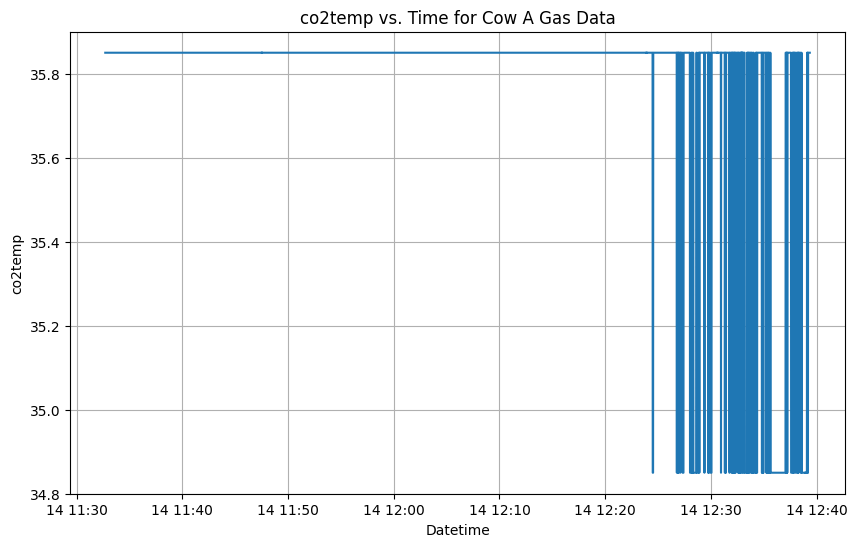

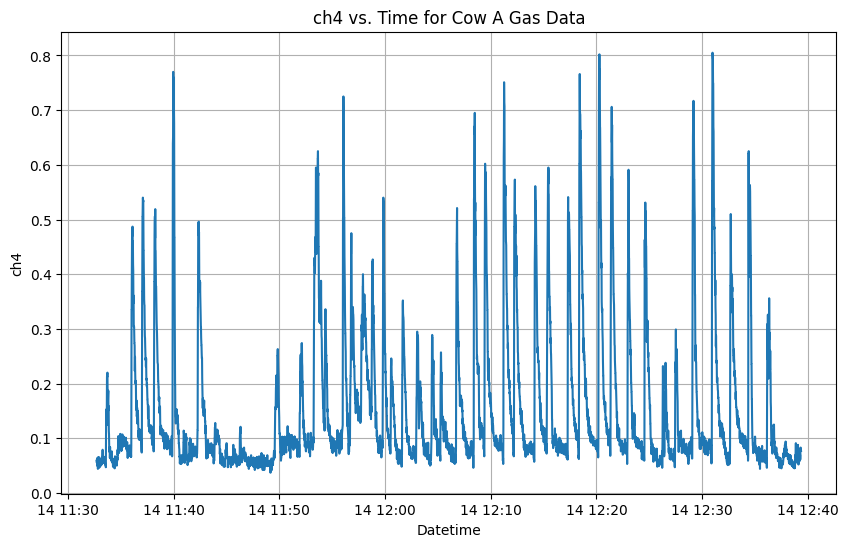

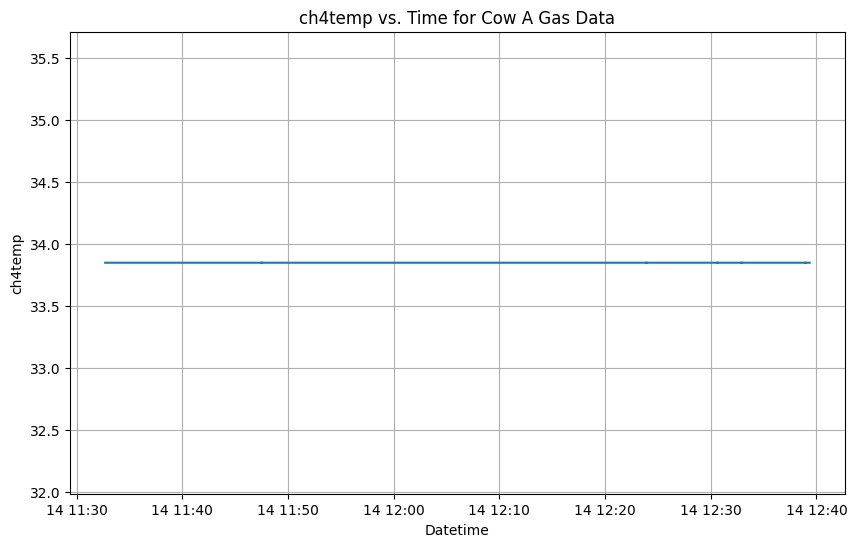

In [32]:

for col in cowB_gas_df.columns:
  plt.figure(figsize=(10, 6))
  plt.plot(cowB_gas_df.index, cowB_gas_df[col])
  plt.xlabel('Datetime')
  plt.ylabel(col)
  plt.title(f'{col} vs. Time for Cow A Gas Data')
  plt.grid(True)
  plt.show()

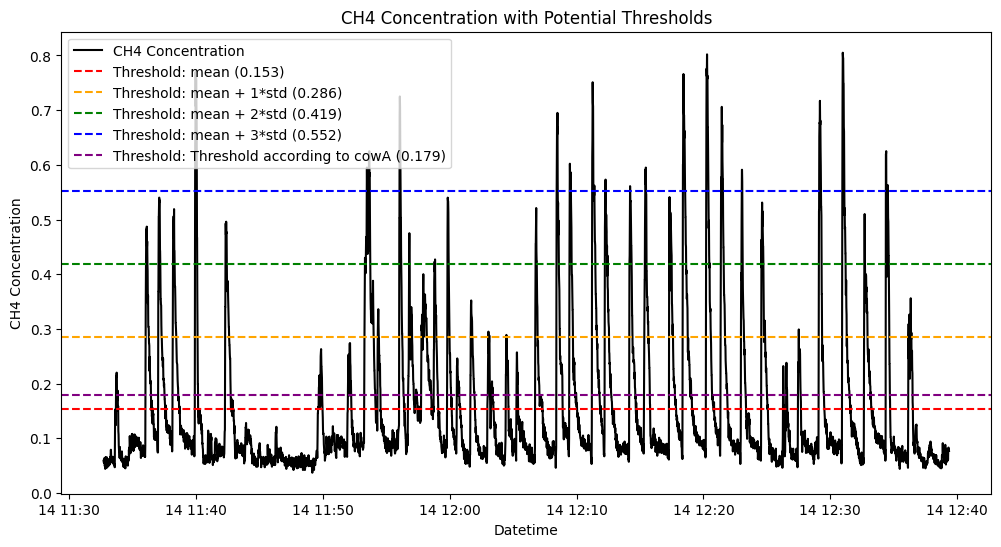

mean: 0.153
mean + 1*std: 0.286
mean + 2*std: 0.419
mean + 3*std: 0.552
Threshold according to cowA: 0.179


In [33]:
ch4_data = cowB_gas_df['ch4']

# Calculate basic statistics
mean_ch4 = ch4_data.mean()
std_ch4 = ch4_data.std()

# Define potential thresholds with colors
thresholds = {
    'mean': (mean_ch4, 'red'),
    'mean + 1*std': (mean_ch4 + 1 * std_ch4, 'orange'),
    'mean + 2*std': (mean_ch4 + 2 * std_ch4, 'green'),
    'mean + 3*std': (mean_ch4 + 3 * std_ch4, 'blue'),
    'Threshold according to cowA': (0.179, 'purple'),


}

# Plot the data and thresholds
plt.figure(figsize=(12, 6))
plt.plot(cowB_gas_df.index, ch4_data, label='CH4 Concentration', color='black')
for label, (value, color) in thresholds.items():
    plt.axhline(y=value, linestyle='--', color=color, label=f'Threshold: {label} ({value:.3f})')

plt.title('CH4 Concentration with Potential Thresholds')
plt.xlabel('Datetime')
plt.ylabel('CH4 Concentration')
plt.legend()
plt.show()

# Print threshold values
for label, (value, _) in thresholds.items():
    print(f'{label}: {value:.3f}')

The threshold 0.179 seems alright as all the peaks are after that moslty.

Analysing for cowB_therm0_df

In [34]:
data_insights(cowB_therm0_df)

info:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time_ms        99999 non-null  int64  
 1   thermistor_id  99999 non-null  int64  
 2   temperature    99999 non-null  float64
 3   raw            99999 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


None


desc:



,time_ms,thermistor_id,temperature,raw
count,9.999900e+04,99999.0,99999.000000,99999.000000
mean,1.723637e+12,0.0,27.608342,1941.718667
std,1.154655e+06,0.0,3.782262,115.928564
min,1.723635e+12,0.0,-273.150000,0.000000
25%,1.723636e+12,0.0,26.393737,1868.000000
50%,1.723637e+12,0.0,28.185579,1917.000000
75%,1.723638e+12,0.0,29.404770,1990.000000
max,1.723639e+12,0.0,203.549349,2240.000000



unique:



,0
time_ms,99999
thermistor_id,1
temperature,753
raw,753



nulls:
 time_ms          0
thermistor_id    0
temperature      0
raw              0
dtype: int64
duplicates: 0


Some outliers are there but rest is good

> Add blockquote



Analysing cowB_therm2_df

In [35]:
data_insights(cowB_therm2_df)

info:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99998 entries, 0 to 99997
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time_ms        98875 non-null  float64
 1   thermistor_id  98875 non-null  float64
 2   temperature    98875 non-null  float64
 3   raw            98875 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


None


desc:



,time_ms,thermistor_id,temperature,raw
count,9.887500e+04,98875.0,98875.000000,98875.000000
mean,1.723637e+12,2.0,30.375305,1831.878645
std,1.160298e+06,0.0,3.496907,135.441616
min,1.723635e+12,2.0,20.886986,42.000000
25%,1.723636e+12,2.0,29.054959,1748.000000
50%,1.723637e+12,2.0,31.454193,1787.000000
75%,1.723638e+12,2.0,32.458073,1882.000000
max,1.723639e+12,2.0,206.535572,2220.000000



unique:



,0
time_ms,98875
thermistor_id,1
temperature,870
raw,870



nulls:
 time_ms          1123
thermistor_id    1123
temperature      1123
raw              1123
dtype: int64
duplicates: 1122


Nulls, duplicates and outliers are there

# Cleaning and merging the data

In [36]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

cows = ['A', 'B']

# Dictionary to hold merged data for each cow (if needed)
merged_data = {}

for cow in cows:
    # --- Load datasets for the cow ---
    therm0_file = os.path.join(GOOGLE_DRIVE_PATH, f'cow{cow}_therm-0.csv')
    therm2_file = os.path.join(GOOGLE_DRIVE_PATH, f'cow{cow}_therm-2.csv')
    gas_file    = os.path.join(GOOGLE_DRIVE_PATH, f'cow{cow}_gas.csv')

    therm0_df = pd.read_csv(therm0_file)
    therm2_df = pd.read_csv(therm2_file)
    gas_df    = pd.read_csv(gas_file)

    # Convert timestamps to datetime (flooring to millisecond precision)
    therm0_df['datetime'] = pd.to_datetime(therm0_df['time_ms'], unit='ms').dt.floor('ms')
    therm2_df['datetime'] = pd.to_datetime(therm2_df['time_ms'], unit='ms').dt.floor('ms')
    gas_df['datetime']    = pd.to_datetime(gas_df['epoch_ms'], unit='ms').dt.floor('ms')

    # Drop unnecessary columns
    therm0_df.drop(columns=['time_ms', 'thermistor_id', 'raw'], inplace=True, errors='ignore')
    therm2_df.drop(columns=['time_ms', 'thermistor_id', 'raw'], inplace=True, errors='ignore')
    gas_df.drop(columns=['epoch_ms'], inplace=True, errors='ignore')

    # Rename temperature columns for clarity
    therm0_df.rename(columns={'temperature': 'temp0'}, inplace=True)
    therm2_df.rename(columns={'temperature': 'temp2'}, inplace=True)

    # Remove duplicate timestamps by taking the mean
    therm0_df = therm0_df.groupby('datetime').mean()
    therm2_df = therm2_df.groupby('datetime').mean()
    gas_df    = gas_df.groupby('datetime').mean()

    # Remove outliers based on temperature using IQR method
    therm0_df = remove_outliers(therm0_df, 'temp0')
    therm2_df = remove_outliers(therm2_df, 'temp2')

    # Get the overall time range across the datasets
    min_time = min(therm0_df.index.min(), therm2_df.index.min(), gas_df.index.min())
    max_time = max(therm0_df.index.max(), therm2_df.index.max(), gas_df.index.max())
    print(f" - Cow {cow} time range: {min_time} to {max_time}")

    # Generate a common datetime index (40ms resolution)
    common_index = pd.date_range(start=min_time, end=max_time, freq='40ms')

    # Resample thermistor data using spline interpolation (order=2)
    temp0_series = therm0_df.reindex(common_index).interpolate(method='spline', order=2)
    temp2_series = therm2_df.reindex(common_index).interpolate(method='spline', order=2)

    # Resample gas data with forward fill to match the common index
    gas_resampled = gas_df.resample('40ms').ffill()

    # Instead of concatenating directly, merge thermistor data with gas data using merge_asof.
    # First, combine thermistor data (they share the same datetime index)
    therm_combined = pd.concat([temp0_series, temp2_series], axis=1).reset_index().rename(columns={'index': 'datetime'})
    gas_resampled_reset = gas_resampled.reset_index()  # Ensure 'datetime' is a column

    # Perform a merge_asof to align therm_combined with gas data on the nearest datetime
    merged_df = pd.merge_asof(
        therm_combined,
        gas_resampled_reset,
        on='datetime',
        direction='nearest',
        tolerance=pd.Timedelta("40ms")
    )

    # Set the datetime column back as the index
    merged_df.set_index('datetime', inplace=True)

    # Fill any remaining NaNs (first forward fill then backward fill)
    merged_df.fillna(method='ffill', inplace=True)
    merged_df.fillna(method='bfill', inplace=True)

    # Save merged data to CSV
    output_file = f'cow{cow}_merged.csv'
    merged_df.to_csv(output_file)
    print(f"✅ Saved merged dataset for Cow {cow} -> {output_file} (rows: {len(merged_df)})")

    # Store in dictionary (if needed for further processing)
    merged_data[cow] = merged_df


 - Cow A time range: 2024-08-13 00:00:00.030000 to 2024-08-13 01:06:39.990000
✅ Saved merged dataset for Cow A -> cowA_merged.csv (rows: 100000)
 - Cow B time range: 2024-08-14 11:32:42.289000 to 2024-08-14 12:39:21.831000
✅ Saved merged dataset for Cow B -> cowB_merged.csv (rows: 99989)


In [37]:
merged_df_A = pd.read_csv( 'cowA_merged.csv')
merged_df_A

,datetime,temp0,temp2,co2,co2temp,ch4,ch4temp
0,2024-08-13 00:00:00.030,28.111389,26.174637,0.782,34.849998,0.068,33.849998
1,2024-08-13 00:00:00.070,28.111389,26.345016,0.782,34.849998,0.068,33.849998
2,2024-08-13 00:00:00.110,28.111389,26.345016,0.782,34.849998,0.068,33.849998
3,2024-08-13 00:00:00.150,28.111389,26.613211,0.782,34.849998,0.068,33.849998
4,2024-08-13 00:00:00.190,28.111389,25.606007,0.782,34.849998,0.068,33.849998
...,...,...,...,...,...,...,...
99995,2024-08-13 01:06:39.830,29.273962,27.004344,1.158,35.849998,0.087,33.849998
99996,2024-08-13 01:06:39.870,29.273366,27.004344,1.158,35.849998,0.087,33.849998
99997,2024-08-13 01:06:39.910,29.272768,26.979861,1.158,35.849998,0.087,33.849998
99998,2024-08-13 01:06:39.950,29.272169,26.930911,1.158,35.849998,0.087,33.849998


In [38]:
merged_df_B = pd.read_csv( 'cowB_merged.csv')
merged_df_B

,datetime,temp0,temp2,co2,co2temp,ch4,ch4temp
0,2024-08-14 11:32:42.289,25.446897,29.104858,0.643,35.849998,0.059,33.849998
1,2024-08-14 11:32:42.329,25.147778,29.104858,0.643,35.849998,0.059,33.849998
2,2024-08-14 11:32:42.369,25.147127,29.104858,0.643,35.849998,0.059,33.849998
3,2024-08-14 11:32:42.409,25.146477,29.104858,0.643,35.849998,0.059,33.849998
4,2024-08-14 11:32:42.449,25.543706,29.104858,0.643,35.849998,0.059,33.849998
...,...,...,...,...,...,...,...
99984,2024-08-14 12:39:21.649,30.207719,30.075324,2.059,35.849998,0.078,33.849998
99985,2024-08-14 12:39:21.689,30.210511,30.078026,2.059,35.849998,0.078,33.849998
99986,2024-08-14 12:39:21.729,30.213304,30.080729,2.059,35.849998,0.078,33.849998
99987,2024-08-14 12:39:21.769,30.216098,30.083433,2.059,35.849998,0.078,33.849998


## Creating labels based on threshold value of ch4

In [39]:
def add_label_column(df):
    df['label'] = (df['ch4'] > 0.179).astype(int)
    return df

merged_df_A = add_label_column(merged_df_A)
merged_df_A


,datetime,temp0,temp2,co2,co2temp,ch4,ch4temp,label
0,2024-08-13 00:00:00.030,28.111389,26.174637,0.782,34.849998,0.068,33.849998,0
1,2024-08-13 00:00:00.070,28.111389,26.345016,0.782,34.849998,0.068,33.849998,0
2,2024-08-13 00:00:00.110,28.111389,26.345016,0.782,34.849998,0.068,33.849998,0
3,2024-08-13 00:00:00.150,28.111389,26.613211,0.782,34.849998,0.068,33.849998,0
4,2024-08-13 00:00:00.190,28.111389,25.606007,0.782,34.849998,0.068,33.849998,0
...,...,...,...,...,...,...,...,...
99995,2024-08-13 01:06:39.830,29.273962,27.004344,1.158,35.849998,0.087,33.849998,0
99996,2024-08-13 01:06:39.870,29.273366,27.004344,1.158,35.849998,0.087,33.849998,0
99997,2024-08-13 01:06:39.910,29.272768,26.979861,1.158,35.849998,0.087,33.849998,0
99998,2024-08-13 01:06:39.950,29.272169,26.930911,1.158,35.849998,0.087,33.849998,0


In [40]:
merged_df_B = add_label_column(merged_df_B)
merged_df_B

,datetime,temp0,temp2,co2,co2temp,ch4,ch4temp,label
0,2024-08-14 11:32:42.289,25.446897,29.104858,0.643,35.849998,0.059,33.849998,0
1,2024-08-14 11:32:42.329,25.147778,29.104858,0.643,35.849998,0.059,33.849998,0
2,2024-08-14 11:32:42.369,25.147127,29.104858,0.643,35.849998,0.059,33.849998,0
3,2024-08-14 11:32:42.409,25.146477,29.104858,0.643,35.849998,0.059,33.849998,0
4,2024-08-14 11:32:42.449,25.543706,29.104858,0.643,35.849998,0.059,33.849998,0
...,...,...,...,...,...,...,...,...
99984,2024-08-14 12:39:21.649,30.207719,30.075324,2.059,35.849998,0.078,33.849998,0
99985,2024-08-14 12:39:21.689,30.210511,30.078026,2.059,35.849998,0.078,33.849998,0
99986,2024-08-14 12:39:21.729,30.213304,30.080729,2.059,35.849998,0.078,33.849998,0
99987,2024-08-14 12:39:21.769,30.216098,30.083433,2.059,35.849998,0.078,33.849998,0


The data is for different days for both cows which may cause issue and might require subject wise training

In [41]:
merged_df_A.to_csv('cowA_merged.csv', index=False)
merged_df_B.to_csv('cowB_merged.csv', index=False)


# Modeling

## Data split
(70% train, 15% validation, 15% test)

In [42]:
# Load merged data
merged_data = {
    'A': pd.read_csv('cowA_merged.csv'),
    'B': pd.read_csv('cowB_merged.csv')
}

# Combine both cows' data
df_base = pd.concat(merged_data.values())
df_base.sort_index(inplace=True)

# Extract labels
y = df_base['label'].values

# Determine split indices (70% train, 15% validation, 15% test)
n = len(y)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

#Baseline

For baseline, lets take the simplest approach where there is always no eructation, i.e. we go with the majority class always

In [43]:
# Find majority class in training set
most_common_label = Counter(y_train).most_common(1)[0][0]

# Predict majority class for each split
y_train_pred = np.full_like(y_train, most_common_label)
y_val_pred = np.full_like(y_val, most_common_label)
y_test_pred = np.full_like(y_test, most_common_label)

# Compute baseline accuracy for each split
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Majority Class Baseline Accuracy:\nTrain: {train_acc:.4f}, Validation: {val_acc:.4f}, Test: {test_acc:.4f}")


Majority Class Baseline Accuracy:
Train: 0.8057, Validation: 0.8050, Test: 0.8155


The accuracy of this is already very high and our goal is to beat this

## Training

### LSTM

Since our data is multivariate, we can't use SARIMA. LSTM works pretty good for capturing temporal dependencies even in multivariate data but the data isn't much. We could use traditional ML models like XGboost which are better for small datasets, but lets try lstm first

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# Function to create sliding window sequences for time series
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)


# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the features
for cow, df in merged_data.items():
    df[['temp0', 'temp2']] = scaler.fit_transform(df[['temp0', 'temp2']])

# Continue with your existing code
X_all, y_all = [], []

window_size = 25  # window length for 1 seconds

for cow, df in merged_data.items():
    print(f"\nProcessing Cow {cow}...")

    if 'label' not in df.columns:
        raise ValueError(f"Label column missing in cow {cow}'s data.")

    df.sort_index(inplace=True)

    X = df[['temp0', 'temp2']].values
    y = df['label'].values

    X_seq, y_seq = create_sequences(X, y, window_size)

    X_all.append(X_seq)
    y_all.append(y_seq)

X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

print(f"Total combined sequences: {X_all.shape[0]}")

X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

print(f"Training: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")


Processing Cow A...

Processing Cow B...
Total combined sequences: 199939
Training: 139957, Validation: 29991, Test: 29991


In [51]:
# Build LSTM model
model = Sequential([
    LSTM(50, input_shape=(window_size, X_all.shape[2])),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50)                  │          10,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,651 (41.61 KB)

 Trainable params: 10,651 (41.61 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stop, model_checkpoint],
                    verbose=1)

# Evaluate model on test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/50
4369/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8080 - loss: 0.4758
Epoch 1: val_loss improved from inf to 0.45795, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8080 - loss: 0.4758 - val_accuracy: 0.8060 - val_loss: 0.4580
Epoch 2/50
4370/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8081 - loss: 0.4550
Epoch 2: val_loss improved from 0.45795 to 0.45643, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.8081 - loss: 0.4550 - val_accuracy: 0.8060 - val_loss: 0.4564
Epoch 3/50
4370/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8080 - loss: 0.4544
Epoch 3: val_loss did not improve from 0.45643
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.8080 - loss: 0.4544 - val_accuracy: 0.8060 - val_loss: 0.4697
Epoch 4/50
4364/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8081 - loss: 0.4524
Epoch 4: val_loss improved from 0.45643 to 0.45538, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.8081 - loss: 0.4524 - val_accuracy: 0.8060 - val_loss: 0.4554
Epoch 5/50
4371/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8079 - loss: 0.4520
Epoch 5: val_loss improved from 0.45538 to 0.45396, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - accuracy: 0.8079 - loss: 0.4520 - val_accuracy: 0.8060 - val_loss: 0.4540
Epoch 6/50
4367/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8092 - loss: 0.4503
Epoch 6: val_loss improved from 0.45396 to 0.44959, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.8092 - loss: 0.4503 - val_accuracy: 0.8074 - val_loss: 0.4496
Epoch 7/50
4371/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8079 - loss: 0.4505
Epoch 7: val_loss did not improve from 0.44959
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.8079 - loss: 0.4505 - val_accuracy: 0.8080 - val_loss: 0.4518
Epoch 8/50
4371/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8081 - loss: 0.4485
Epoch 8: val_loss improved from 0.44959 to 0.44891, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.8081 - loss: 0.4485 - val_accuracy: 0.8074 - val_loss: 0.4489
Epoch 9/50
4371/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8111 - loss: 0.4457
Epoch 9: val_loss did not improve from 0.44891
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.8111 - loss: 0.4457 - val_accuracy: 0.8076 - val_loss: 0.4492
Epoch 10/50
4368/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8091 - loss: 0.4480
Epoch 10: val_loss did not improve from 0.44891
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.8091 - loss: 0.4480 - val_accuracy: 0.8073 - val_loss: 0.4501
Epoch 11/50
4369/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8095 - loss: 0.4457
Epoch 11: val_loss did not improve from 0.44891
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.8095 - loss: 0.4457 - val_accuracy: 0.8075 - val_loss: 0.4497
Epoch 12/50
4373/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8102 - loss: 0.4454
Epoch 12: val_loss imp

4374/4374 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.8102 - loss: 0.4454 - val_accuracy: 0.8078 - val_loss: 0.4487
Epoch 13/50
4371/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8116 - loss: 0.4429
Epoch 13: val_loss improved from 0.44875 to 0.44779, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.8116 - loss: 0.4429 - val_accuracy: 0.8075 - val_loss: 0.4478
Epoch 14/50
4370/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8088 - loss: 0.4460
Epoch 14: val_loss improved from 0.44779 to 0.44616, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.8088 - loss: 0.4460 - val_accuracy: 0.8085 - val_loss: 0.4462
Epoch 15/50
4366/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8094 - loss: 0.4460
Epoch 15: val_loss did not improve from 0.44616
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.8094 - loss: 0.4460 - val_accuracy: 0.8075 - val_loss: 0.4517
Epoch 16/50
4369/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8089 - loss: 0.4477
Epoch 16: val_loss did not improve from 0.44616
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.8089 - loss: 0.4477 - val_accuracy: 0.8077 - val_loss: 0.4467
Epoch 17/50
4369/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8077 - loss: 0.4480
Epoch 17: val_loss did not improve from 0.44616
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - accuracy: 0.8077 - loss: 0.4480 - val_accuracy: 0.8070 - val_loss: 0.4490
Epoch 18/50
4368/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8106 - loss: 0.4436
Epoch 18: val_loss i

4374/4374 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.8106 - loss: 0.4436 - val_accuracy: 0.8074 - val_loss: 0.4441
Epoch 19/50
4367/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8111 - loss: 0.4414
Epoch 19: val_loss did not improve from 0.44411
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.8111 - loss: 0.4414 - val_accuracy: 0.8076 - val_loss: 0.4477
Epoch 20/50
4365/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8099 - loss: 0.4413
Epoch 20: val_loss improved from 0.44411 to 0.44111, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.8099 - loss: 0.4413 - val_accuracy: 0.8082 - val_loss: 0.4411
Epoch 21/50
4366/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8103 - loss: 0.4361
Epoch 21: val_loss did not improve from 0.44111
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.8103 - loss: 0.4361 - val_accuracy: 0.8076 - val_loss: 0.4420
Epoch 22/50
4372/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8095 - loss: 0.4365
Epoch 22: val_loss improved from 0.44111 to 0.43905, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.8095 - loss: 0.4365 - val_accuracy: 0.8088 - val_loss: 0.4390
Epoch 23/50
4365/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8095 - loss: 0.4342
Epoch 23: val_loss improved from 0.43905 to 0.43670, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.8095 - loss: 0.4342 - val_accuracy: 0.8078 - val_loss: 0.4367
Epoch 24/50
4369/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8108 - loss: 0.4313
Epoch 24: val_loss improved from 0.43670 to 0.43467, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.8108 - loss: 0.4313 - val_accuracy: 0.8079 - val_loss: 0.4347
Epoch 25/50
4368/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8080 - loss: 0.4344
Epoch 25: val_loss improved from 0.43467 to 0.43218, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.8080 - loss: 0.4344 - val_accuracy: 0.8079 - val_loss: 0.4322
Epoch 26/50
4372/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8105 - loss: 0.4271
Epoch 26: val_loss improved from 0.43218 to 0.43101, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.8105 - loss: 0.4271 - val_accuracy: 0.8087 - val_loss: 0.4310
Epoch 27/50
4365/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8104 - loss: 0.4280
Epoch 27: val_loss improved from 0.43101 to 0.43042, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.8104 - loss: 0.4280 - val_accuracy: 0.8076 - val_loss: 0.4304
Epoch 28/50
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8092 - loss: 0.4285
Epoch 28: val_loss improved from 0.43042 to 0.42909, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.8092 - loss: 0.4285 - val_accuracy: 0.8076 - val_loss: 0.4291
Epoch 29/50
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8109 - loss: 0.4256
Epoch 29: val_loss did not improve from 0.42909
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.8109 - loss: 0.4256 - val_accuracy: 0.8072 - val_loss: 0.4321
Epoch 30/50
4373/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8111 - loss: 0.4263
Epoch 30: val_loss improved from 0.42909 to 0.42745, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.8111 - loss: 0.4263 - val_accuracy: 0.8093 - val_loss: 0.4275
Epoch 31/50
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8125 - loss: 0.4233
Epoch 31: val_loss did not improve from 0.42745
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - accuracy: 0.8125 - loss: 0.4233 - val_accuracy: 0.8082 - val_loss: 0.4296
Epoch 32/50
4365/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8119 - loss: 0.4237
Epoch 32: val_loss improved from 0.42745 to 0.42522, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.8119 - loss: 0.4237 - val_accuracy: 0.8084 - val_loss: 0.4252
Epoch 33/50
4368/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8103 - loss: 0.4241
Epoch 33: val_loss improved from 0.42522 to 0.42490, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.8103 - loss: 0.4241 - val_accuracy: 0.8101 - val_loss: 0.4249
Epoch 34/50
4366/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8082 - loss: 0.4252
Epoch 34: val_loss improved from 0.42490 to 0.42229, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.8083 - loss: 0.4252 - val_accuracy: 0.8103 - val_loss: 0.4223
Epoch 35/50
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8110 - loss: 0.4216
Epoch 35: val_loss did not improve from 0.42229
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.8110 - loss: 0.4216 - val_accuracy: 0.8084 - val_loss: 0.4260
Epoch 36/50
4367/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8110 - loss: 0.4213
Epoch 36: val_loss did not improve from 0.42229
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.8110 - loss: 0.4213 - val_accuracy: 0.8095 - val_loss: 0.4231
Epoch 37/50
4368/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8109 - loss: 0.4200
Epoch 37: val_loss improved from 0.42229 to 0.41930, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.8109 - loss: 0.4200 - val_accuracy: 0.8097 - val_loss: 0.4193
Epoch 38/50
4369/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8122 - loss: 0.4184
Epoch 38: val_loss did not improve from 0.41930
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.8122 - loss: 0.4184 - val_accuracy: 0.8092 - val_loss: 0.4203
Epoch 39/50
4364/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8142 - loss: 0.4154
Epoch 39: val_loss did not improve from 0.41930
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.8142 - loss: 0.4154 - val_accuracy: 0.8095 - val_loss: 0.4218
Epoch 40/50
4371/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8102 - loss: 0.4187
Epoch 40: val_loss improved from 0.41930 to 0.41860, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.8102 - loss: 0.4187 - val_accuracy: 0.8106 - val_loss: 0.4186
Epoch 41/50
4373/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8103 - loss: 0.4173
Epoch 41: val_loss did not improve from 0.41860
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.8103 - loss: 0.4173 - val_accuracy: 0.8095 - val_loss: 0.4188
Epoch 42/50
4371/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8121 - loss: 0.4165
Epoch 42: val_loss improved from 0.41860 to 0.41809, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.8121 - loss: 0.4165 - val_accuracy: 0.8103 - val_loss: 0.4181
Epoch 43/50
4371/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8131 - loss: 0.4148
Epoch 43: val_loss improved from 0.41809 to 0.41719, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.8131 - loss: 0.4148 - val_accuracy: 0.8115 - val_loss: 0.4172
Epoch 44/50
4368/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8124 - loss: 0.4149
Epoch 44: val_loss did not improve from 0.41719
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.8124 - loss: 0.4149 - val_accuracy: 0.8114 - val_loss: 0.4222
Epoch 45/50
4365/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8134 - loss: 0.4135
Epoch 45: val_loss improved from 0.41719 to 0.41639, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.8134 - loss: 0.4135 - val_accuracy: 0.8115 - val_loss: 0.4164
Epoch 46/50
4373/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8121 - loss: 0.4114
Epoch 46: val_loss did not improve from 0.41639
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.8121 - loss: 0.4114 - val_accuracy: 0.8106 - val_loss: 0.4164
Epoch 47/50
4370/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8129 - loss: 0.4123
Epoch 47: val_loss improved from 0.41639 to 0.41394, saving model to best_model.h5


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.8129 - loss: 0.4123 - val_accuracy: 0.8121 - val_loss: 0.4139
Epoch 48/50
4371/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8125 - loss: 0.4124
Epoch 48: val_loss did not improve from 0.41394
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - accuracy: 0.8125 - loss: 0.4124 - val_accuracy: 0.8106 - val_loss: 0.4198
Epoch 49/50
4366/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8127 - loss: 0.4119
Epoch 49: val_loss did not improve from 0.41394
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.8127 - loss: 0.4119 - val_accuracy: 0.8098 - val_loss: 0.4181
Epoch 50/50
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8120 - loss: 0.4122
Epoch 50: val_loss did not improve from 0.41394
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.8120 - loss: 0.4122 - val_accuracy: 0.8112 - val_loss: 0.4171
Test Accuracy: 0.81


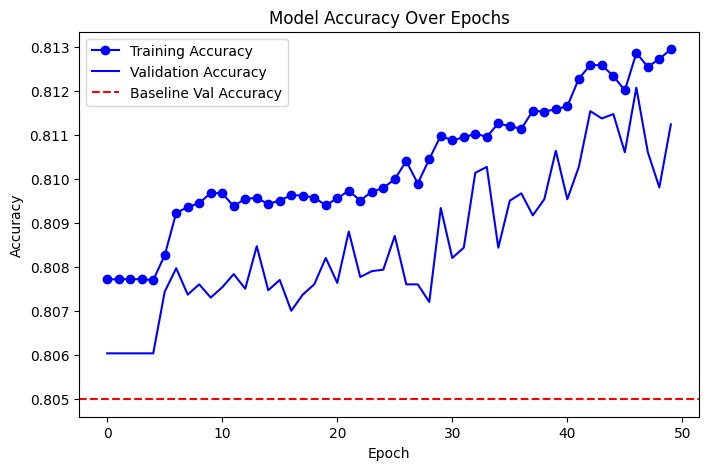

In [58]:

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'b-', label='Validation Accuracy')
plt.axhline(y=0.8050, color='r', linestyle='--', label='Baseline Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

the accuracy is little over baseline and there is slight overfitting too

Lets try XGBoost now. To mimic LSTM's ability to look at sequences, we explicitly create time-based features using lagged values and rolling window statistics. These help XGBoost understand patterns over time.

### Feature engineering

In [59]:

# Function to create lagged features for time series
def create_lagged_features(df, window_size):
    """
    Create lagged features for temp0 and temp2 over a given window_size.
    """
    for i in range(1, window_size + 1):
        df[f'temp0_lag{i}'] = df['temp0'].shift(i)
        df[f'temp2_lag{i}'] = df['temp2'].shift(i)

    # Rolling window statistics (mean & std)
    df['temp0_roll_mean'] = df['temp0'].rolling(window=window_size).mean()
    df['temp0_roll_std'] = df['temp0'].rolling(window=window_size).std()
    df['temp2_roll_mean'] = df['temp2'].rolling(window=window_size).mean()
    df['temp2_roll_std'] = df['temp2'].rolling(window=window_size).std()

    # Drop NaN values after shifting
    return df.dropna().reset_index(drop=True)

# Sliding window size
window_size = 10

# Initialize lists for combined dataset
X_all, y_all = [], []

for cow, df in merged_data.items():
    print(f"\nProcessing Cow {cow}...")

    if 'label' not in df.columns:
        raise ValueError(f"Label column missing in cow {cow}'s data.")

    df.sort_index(inplace=True)  # Ensure chronological order
    df = create_lagged_features(df, window_size)  # Generate features

    # Select only thermistor-based features
    feature_cols = [col for col in df.columns if col.startswith('temp0') or col.startswith('temp2')]

    X = df[feature_cols]  # Features (temp0 & temp2 only)
    y = df['label']  # Target variable (eructation event)

    X_all.append(X)
    y_all.append(y)

# Combine all cows' data
X_all = pd.concat(X_all, axis=0)
y_all = pd.concat(y_all, axis=0)

# Train-test-validation split
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

# Normalize Features (Optional but recommended for XGBoost)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")





Processing Cow A...

Processing Cow B...
Training: 139978, Validation: 29995, Test: 29996


### Training XGBoost

In [62]:
# Validation Predictions
y_val_pred = xgb_model.predict(X_val)
y_val_pred_prob = xgb_model.predict_proba(X_val)[:, 1]

# Final Test Predictions
y_test_pred = xgb_model.predict(X_test)
y_test_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Validation Metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)

# Test Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

# Print Validation Results
print("\n🔹 Validation Set Metrics 🔹")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation ROC AUC: {val_roc_auc:.4f}")

# Print Test Results
print("\n🔹 Test Set Metrics 🔹")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")



🔹 Validation Set Metrics 🔹
Validation Accuracy: 0.8125
Validation Precision: 0.7915
Validation Recall: 0.0387
Validation ROC AUC: 0.7762

🔹 Test Set Metrics 🔹
Test Accuracy: 0.8152
Test Precision: 0.8264
Test Recall: 0.0415
Test ROC AUC: 0.7744


XGBoost showed very slightly improved validation accuracy

## Next steps for better modeling could be:
1. Use Synthetic Data (GANs for Time Series) for increasing the datapoints and train better and to sync. the dates for both the cows.
2. Use Transfer Learning
3. Use a small LSTM model with dropout to prevent overfitting and also hyperparameter tuning.
4. Trying a hybrid approach (XGBoost + LSTM).
3. Try GRUs
